In [1]:
!pip install SimpleITK nibabel plotly

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk
import tensorflow as tf
import cv2
import os

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
#!ls /kaggle/input/
# Check the root directory for both datasets
!ls /kaggle/input/

# List files in BRATS dataset
!ls /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001

# List files in LUNA16 dataset
!ls /kaggle/input/luna-lung-cancer-dataset/seg-lungs-LUNA16


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


brats20-dataset-training-validation  luna-lung-cancer-dataset
BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1ce.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1.nii
seg-lungs-LUNA16


In [4]:
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Define paths for MRI and CT scans
mri_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
ct_path = '/kaggle/input/luna-lung-cancer-dataset/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'

# Load MRI data using nibabel
mri_image = nib.load(mri_path)
mri_data = mri_image.get_fdata()

# Load CT data using SimpleITK
ct_image = sitk.ReadImage(ct_path)
ct_data = sitk.GetArrayFromImage(ct_image)

print("MRI data shape:", mri_data.shape)
print("CT data shape:", ct_data.shape)


MRI data shape: (240, 240, 155)
CT data shape: (194, 512, 512)


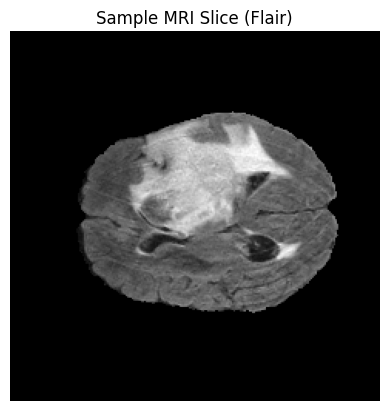

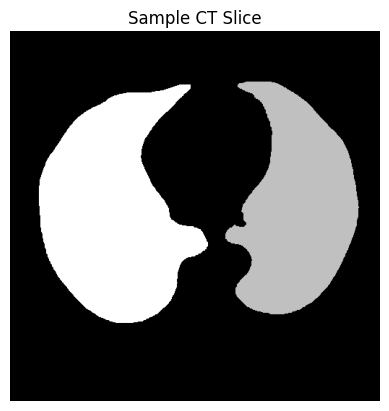

In [5]:
# Display a middle slice of the MRI scan
slice_idx_mri = mri_data.shape[2] // 2
plt.imshow(mri_data[:, :, slice_idx_mri], cmap='gray')
plt.title('Sample MRI Slice (Flair)')
plt.axis('off')
plt.show()

# Display a middle slice of the CT scan
slice_idx_ct = ct_data.shape[0] // 2
plt.imshow(ct_data[slice_idx_ct, :, :], cmap='gray')
plt.title('Sample CT Slice')
plt.axis('off')
plt.show()


In [6]:
import nibabel as nib
import numpy as np

# Load MRI data (BraTS 2020 FLAIR modality)
def load_mri_data(mri_path):
    """Load MRI data from a NIfTI file and normalize it."""
    # Load the NIfTI file
    mri_img = nib.load(mri_path)
    mri_data = mri_img.get_fdata()  # Get the 3D array from the NIfTI file
    
    # Normalize the data to [0, 1]
    mri_data = (mri_data - np.min(mri_data)) / (np.max(mri_data) - np.min(mri_data))
    
    return mri_data

mri_data = load_mri_data(mri_path)
print(f"MRI Data Shape: {mri_data.shape}")


MRI Data Shape: (240, 240, 155)


In [7]:
import SimpleITK as sitk

# Load CT data (LUNA 16)
def load_ct_data(ct_path):
    """Load CT data from a .mhd file."""
    # Read the .mhd file (MetaImage format)
    ct_img = sitk.ReadImage(ct_path)
    
    # Convert to a NumPy array
    ct_data = sitk.GetArrayFromImage(ct_img)
    
    # Normalize the CT data
    ct_data = (ct_data - np.min(ct_data)) / (np.max(ct_data) - np.min(ct_data))
    
    return ct_data

ct_data = load_ct_data(ct_path)
print(f"CT Data Shape: {ct_data.shape}")


CT Data Shape: (194, 512, 512)


In [8]:
import cv2
import numpy as np

def resize_volume(volume, target_depth, target_height, target_width):
    """Resize 3D volume to the target shape."""
    depth, height, width = volume.shape  # Get original volume shape
    
    # Initialize an empty volume with the target shape
    resized_volume = np.zeros((target_depth, target_height, target_width))
    
    # Resize each slice in the 3D volume for height and width
    for i in range(min(depth, target_depth)):  # Limit to the smaller of original and target depth
        resized_slice = cv2.resize(volume[i], (target_width, target_height), interpolation=cv2.INTER_LINEAR)
        resized_volume[i, :, :] = resized_slice  # Assign resized slice
    
    # Adjust depth dimension (if necessary, by truncating or padding)
    if depth < target_depth:
        # Pad with zeros to reach target depth if original depth is smaller
        padding = ((0, target_depth - depth), (0, 0), (0, 0))
        resized_volume = np.pad(resized_volume, padding, mode='constant')[:target_depth]
    
    return resized_volume

# Example usage with MRI and CT data
# Assuming `mri_data` and `ct_data` are already loaded as numpy arrays with shapes (240, 240, 155) and (194, 512, 512), respectively.

target_shape = (128, 128, 128)

# Resize MRI and CT data
mri_data_resized = resize_volume(mri_data, *target_shape)
ct_data_resized = resize_volume(ct_data, *target_shape)

print(f"Resized MRI Data Shape: {mri_data_resized.shape}")
print(f"Resized CT Data Shape: {ct_data_resized.shape}")


Resized MRI Data Shape: (128, 128, 128)
Resized CT Data Shape: (128, 128, 128)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(volume_data):
    """Apply random augmentation to the 3D data."""
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    # Expand dimensions to make it work with ImageDataGenerator
    volume_data = np.expand_dims(volume_data, axis=-1)  # Add channel dimension
    augmented_data = datagen.flow(volume_data, batch_size=1)
    return augmented_data

# Apply augmentation (you can use this during model training)
mri_data_augmented = augment_data(mri_data_resized)
ct_data_augmented = augment_data(ct_data_resized)


In [10]:
from tensorflow.keras import layers, models
def unet_3d(input_shape):
    """Define the 3D U-Net model with conditional pooling for single-depth inputs."""
    inputs = layers.Input(input_shape)

    # Encoder (downsampling)
    conv1 = layers.Conv3D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling3D((2, 2, 2) if input_shape[2] > 1 else (1, 2, 2))(conv1)  # Conditional pooling

    conv2 = layers.Conv3D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling3D((2, 2, 2) if pool1.shape[2] > 1 else (1, 2, 2))(conv2)

    conv3 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling3D((2, 2, 2) if pool2.shape[2] > 1 else (1, 2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv3D(256, 3, activation='relu', padding='same')(pool3)

    # Decoder (upsampling)
    up5 = layers.UpSampling3D((2, 2, 2))(conv4)
    conv5 = layers.Conv3D(128, 3, activation='relu', padding='same')(up5)

    up6 = layers.UpSampling3D((2, 2, 2))(conv5)
    conv6 = layers.Conv3D(64, 3, activation='relu', padding='same')(up6)

    up7 = layers.UpSampling3D((2, 2, 2))(conv6)
    conv7 = layers.Conv3D(32, 3, activation='relu', padding='same')(up7)

    # Output layer
    output = layers.Conv3D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs, output)
    return model

# Define input shape and compile the model
input_shape = (128, 128, 128, 1)  # Assuming a depth of 128
model = unet_3d(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 128,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 128,  │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d (UpSampling3D)    │ (None, 32, 32, 32,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 32, 32,     │       884,864 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_1 (UpSampling3D)  │ (None, 64, 64, 64,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 64, 64, 64, 64) │       221,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_2 (UpSampling3D)  │ (None, 128, 128, 128,  │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 128, 128, 128,  │        55,328 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 128, 128, 128,  │            33 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,324,033 (8.87 MB)

 Trainable params: 2,324,033 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import numpy as np

# Assuming mri_data_resized and ct_data_resized have shape (128, 128, 128)
X_train_mri = mri_data_resized[..., np.newaxis]  # Shape: (128, 128, 128, 1)
X_train_ct = ct_data_resized[..., np.newaxis] # Shape: (128, 128, 128, 1)
print(X_train_mri.shape)
print(X_train_ct.shape)
# Add a new axis to create a batch of 1 for each volume
mri_data_batch = np.expand_dims(mri_data_resized, axis=0)  # Shape: (1, 128, 128, 128)
ct_data_batch = np.expand_dims(ct_data_resized, axis=0)    # Shape: (1, 128, 128, 128)

# Repeat the data to create 128 samples for each modality
mri_data_repeated = np.repeat(mri_data_batch, 128, axis=0)  # Shape: (128, 128, 128, 128)
ct_data_repeated = np.repeat(ct_data_batch, 128, axis=0)    # Shape: (128, 128, 128, 128)

# Add the channel dimension
mri_data_final = np.expand_dims(mri_data_repeated, axis=-1)  # Shape: (128, 128, 128, 128, 1)
ct_data_final = np.expand_dims(ct_data_repeated, axis=-1)    # Shape: (128, 128, 128, 128, 1)

# Concatenate along the batch dimension
X_train = np.concatenate((mri_data_final, ct_data_final), axis=0)  # Shape: (256, 128, 128, 128, 1)

# Print the shape of the final training data
print("Shape of X_train:", X_train.shape)  # Should output (256, 128, 128, 128, 1)


print(X_train.shape)

# Create target labels: 1 for MRI and 0 for CT
y_train_mri = np.ones((X_train_mri.shape[0], 128, 128, 128, 1))  # Shape: (128, 128, 128, 128, 1)
y_train_ct = np.zeros((X_train_ct.shape[0], 128, 128, 128, 1))  # Shape: (128, 128, 128, 128, 1)

# Concatenate the labels along the batch dimension (axis 0)
y_train = np.concatenate((y_train_mri, y_train_ct), axis=0)  # Shape: (256, 128, 128, 128, 1)
print("Shape of y_train:", y_train.shape)

# Fit the model
history =model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2)


(128, 128, 128, 1)
(128, 128, 128, 1)
Shape of X_train: (256, 128, 128, 128, 1)
(256, 128, 128, 128, 1)
Shape of y_train: (256, 128, 128, 128, 1)
Epoch 1/10


I0000 00:00:1731575101.941053     866 service.cc:145] XLA service 0x7c0c48111130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731575101.941102     866 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-14 09:05:09.811397: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[4,32,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,128,128,128]{4,3,2,1,0}, f32[32,64,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-14 09:05:09.912025: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operatio

51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6302 - loss: 0.6368 - val_accuracy: 0.8456 - val_loss: 0.3073
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9490 - loss: 0.1913 - val_accuracy: 0.8780 - val_loss: 0.3140
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9425 - loss: 0.3687 - val_accuracy: 0.7872 - val_loss: 0.1960
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8998 - loss: 0.3815 - val_accuracy: 0.7676 - val_loss: 0.4084
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9325 - loss: 0.2179 - val_accuracy: 0.8553 - val_loss: 0.2712
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9373 - loss: 0.2986 - val_accuracy: 0.8695 - val_loss: 0.2367
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9500 - loss: 0.1666 - val_accuracy: 0.8758 - val_loss: 0.3622
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9632 - loss: 0.1287 - val_accuracy: 0.8822 - val_loss: 0.2007
Ep

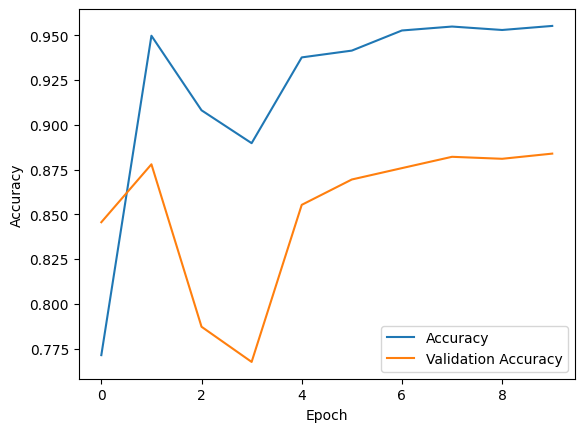

In [12]:
#history = model.fit(X, y, epochs=10, batch_size=4, validation_split=0.2)

# Plot the training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
model.save('/kaggle/working/3d_unet_model.h5')


In [15]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model

model = load_model('3d_unet_model.h5')

st.title("3D U-Net Tumor Detection App")
uploaded_file = st.file_uploader("Upload a medical image slice", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    image = cv2.imdecode(np.frombuffer(uploaded_file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128)).reshape(1, 128, 128, 1) / 255.0

    prediction = model.predict(image)
    st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)
    st.write(f"Tumor Probability: {prediction[0][0][0][0]:.2f}")


2024-11-14 09:20:04.990 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.124 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-11-14 09:20:05.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 09:20:05.131 Thread 'MainThread': missi